### **ECE 657A : Data and Knowledge Modeling and Analysis**

#### **Assignment 3 : Embedding with dimensionality reduction methods and embedding methods for natural language**

### **Import libraries**

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
import pandas as pd
import numpy as np
import re
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action = 'ignore') 

### **Load dataset**

#### CITATION  (CLIMATE-FEVER Dataset)
@misc{diggelmann2020climatefever,
      title={CLIMATE-FEVER: A Dataset for Verification of Real-World Climate Claims},
      author={Thomas Diggelmann and Jordan Boyd-Graber and Jannis Bulian and Massimiliano Ciaramita and Markus Leippold},
      year={2020},
      eprint={2012.00614},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}


In [ ]:
dataset = load_dataset("climate_fever")

Using custom data configuration default
Reusing dataset climate_fever (/root/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


# **[CM1]**

In [ ]:
dataset.data

{'test': pyarrow.Table
 claim: string
 claim_id: string
 claim_label: int64
 evidences: list<item: struct<article: string, entropy: float, evidence: string, evidence_id: string, evidence_label: int64, votes: list<item: string>>>
   child 0, item: struct<article: string, entropy: float, evidence: string, evidence_id: string, evidence_label: int64, votes: list<item: string>>
       child 0, article: string
       child 1, entropy: float
       child 2, evidence: string
       child 3, evidence_id: string
       child 4, evidence_label: int64
       child 5, votes: list<item: string>
           child 0, item: string}

In [ ]:
dataset.column_names

{'test': ['claim', 'claim_id', 'claim_label', 'evidences']}

In [ ]:
dataset.shape

{'test': (1535, 4)}

In [ ]:
datadict= dataset['test']

In [ ]:
datadict[0]

{'claim': 'Global warming is driving polar bears toward extinction',
 'claim_id': '0',
 'claim_label': 0,
 'evidences': [{'article': 'Extinction risk from global warming',
   'entropy': 0.6931471824645996,
   'evidence': '"Recent Research Shows Human Activity Driving Earth Towards Global Extinction Event".',
   'evidence_id': 'Extinction risk from global warming:170',
   'evidence_label': 2,
   'votes': ['SUPPORTS', 'NOT_ENOUGH_INFO', None, None, None]},
  {'article': 'Global warming',
   'entropy': 0.0,
   'evidence': 'Environmental impacts include the extinction or relocation of many species as their ecosystems change, most immediately the environments of coral reefs, mountains, and the Arctic.',
   'evidence_id': 'Global warming:14',
   'evidence_label': 0,
   'votes': ['SUPPORTS', 'SUPPORTS', None, None, None]},
  {'article': 'Global warming',
   'entropy': 0.6931471824645996,
   'evidence': 'Rising temperatures push bees to their physiological limits, and could cause the extinctio

### Data Fields
- claim_id: a string feature, unique claim identifier.
- claim: a string feature, claim text.
- claim_label: a int feature, overall label assigned to claim (based on evidence majority vote). The label correspond to 0: "refutes", 1: "supports" and 2: "not enough info"
- evidences: a list of evidences with fields:
- evidence_id: a string feature, unique evidence identifier.
- evidence_label: a int feature, micro-verdict label. The label correspond to 0: "refutes", 1: "supports" and 2: "not enough info"
- article: a string feature, title of source article (Wikipedia page).
- evidence: a string feature, evidence sentence.
- entropy: a float32 feature, entropy reflecting uncertainty of evidence_label.
- votes: a list of string features, corresponding to individual votes.

### We see from the dataset that the fields "claim" and the "evidence" (within "evidences") have significant word data. Hence we will extract these particular fields of the dataset to build the text corpus for our word2vec model and further analysis.

In [ ]:
sentences = []

In [ ]:
# extract 'claim' and 'evidences' from the dataset
for key in datadict:
    print('claim : ' , key['claim'])
    sentences.append(key['claim'])
    #paragraph = paragraph + key['claim']
    for evidence in key['evidences']:
        print('evidence : ' , evidence['evidence'])
        sentences.append(evidence['evidence'])
        #paragraph = paragraph + evidence['evidence']

### Preparing the dataset :
- word tokenization.
- stop word removal (like 'the','is' etc.)
- lower case conversion.
- punctuation , special characters removal
- word lemmatization

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Preparing the dataset
#sentences = nltk.sent_tokenize(paragraph)

# word tokenization
sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

import string
table = str.maketrans('', '', string.punctuation)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for i in range(len(sentences)):
    # stopword removal
    sentences[i] = [word.lower() for word in sentences[i] if word not in stopwords.words('english')]
    # punctuation removal
    sentences[i] = [word.translate(table) for word in sentences[i]]
    sentences[i] = [word for word in sentences[i] if word.isalnum()]
    # lemmatization of words
    sentences[i] = [lemmatizer.lemmatize(word, pos="v") for word in sentences[i]]

In [ ]:
for i in range(3):
    print(sentences[i])

['global', 'warm', 'drive', 'polar', 'bear', 'toward', 'extinction']
['recent', 'research', 'show', 'human', 'activity', 'drive', 'earth', 'towards', 'global', 'extinction', 'event']
['environmental', 'impact', 'include', 'extinction', 'relocation', 'many', 'species', 'ecosystems', 'change', 'immediately', 'environments', 'coral', 'reef', 'mountains', 'arctic']


### Train-Test split dataset

Splitting the data corpus into train set (80%) and test set (20%) maintaining the order (shuffle = False)

In [ ]:
from sklearn.model_selection import train_test_split

print(len(sentences))

# dividing the data into train and test sets (80%, 20%) with random_state=0
train_set, test_set = train_test_split(sentences, test_size=0.2, random_state=0,shuffle=False)

9210


In [ ]:
print('train: ',len(train_set))
print('test: ',len(test_set))

train:  7368
test:  1842


In [ ]:
for i in range(3):
    print(train_set[i])

['global', 'warm', 'drive', 'polar', 'bear', 'toward', 'extinction']
['recent', 'research', 'show', 'human', 'activity', 'drive', 'earth', 'towards', 'global', 'extinction', 'event']
['environmental', 'impact', 'include', 'extinction', 'relocation', 'many', 'species', 'ecosystems', 'change', 'immediately', 'environments', 'coral', 'reef', 'mountains', 'arctic']


### Initializing and training the Word2vec model 

Initializing and training the word2vec model.
Keeping the min_count as 2 – Ignores all words with total frequency lower than this. This will filter out insignificant words that appear only once in the data corpus.


In [ ]:
# Training the Word2Vec model
model = Word2Vec(min_count=2,seed=0)
model.build_vocab(sentences)  # prepare the model vocabulary
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# # Training the Word2Vec model
# model = Word2Vec(sentences, seed=0, min_count=2)

In [ ]:
model.save("word2vec.model")

In [ ]:
model = Word2Vec.load("word2vec.model")

In [ ]:
words= model.wv.vocab
len(words)

6268

In [ ]:
# getting unique words from the train set
flat_list = []
for sent in train_set:
    for word in sent:
      if word not in flat_list:
        flat_list.append(word)
train_set = flat_list


Obtain the embeddings of the train set

In [ ]:
# map of train_set words and their word2vec embedding
train_embedding ={}
for word in train_set:
    try:
        train_embedding[word]=model.wv[word]
    except KeyError:
        print("The word "+word+" does not appear in this model")

In [ ]:
print(train_embedding.keys())

In [ ]:
# gettign unique words from the test set
flat_list = []
for sent in test_set:
    for word in sent:
      if word not in flat_list:
        flat_list.append(word)
test_set = flat_list

obtaining the embeddings of the test set

In [ ]:
# map of test_set words and their word2vec embedding
test_embedding ={}
for word in test_set:
    try:
        test_embedding[word]=model.wv[word]
    except KeyError:
        print("The word "+word+" does not appear in this model")

In [ ]:
print(test_embedding.keys())

In [ ]:
len(train_embedding.keys())
len(test_embedding.keys())

3913

In [ ]:
for key, value in words.items():
    print(key, ' : ', value)

### Model exploration and analysis 

In [ ]:
# Most similar words
model.most_similar('global', topn=1)

[('warm', 0.9816120862960815)]

#### In the context of the dataset "climate-fever" which is primarily regarding climate change, we can expect that most frequently the words "global" & "warming" appear together. From the word2vec model, we observe the word 'global' is most similar to 'warm' (lemmatized word for 'warming').

In [ ]:
# Most similar words
model.most_similar('climate', topn=1)

[('change', 0.9676931500434875)]

#### Similarly in the context of the dataset "climate-fever" which is primarily regarding climate change, we can expect frequent occurrance of "climate" & "change" appear tofether frequently. From the word2vec model, we observe the words 'climate' and 'change' have the most similarity.

In [ ]:
# Most similar words
model.most_similar('carbon')

[('methane', 0.9804165363311768),
 ('chlorofluorocarbons', 0.9779826402664185),
 ('dioxide', 0.9746006727218628),
 ('nitrous', 0.9659712314605713),
 ('96', 0.9649980068206787),
 ('tropospheric', 0.9622126817703247),
 ('49', 0.9581986665725708),
 ('nonco2', 0.9581005573272705),
 ('oxide', 0.9576266407966614),
 ('release', 0.9563332200050354)]

#### Considering the word "carbon", in the context of the dataset "climate-fever", we observe: 
- 'carbon' has high cosine similarity with 'dioxide'. In word2vec, words that appear together or in the same sentences are considered very similar.
- we see other greenhouse gases like methane, chlorofluorocarbons in the most similar words. The model is able to succesfully identify similar gases.
- we also see words like 'nitrous', 'oxide' , 'tropospheric' etc. which are words associated with 'carbon' and gases in general in most scientific disciplines.

In [ ]:
# Most similar words
model.most_similar('glaciers')

[('antarctic', 0.9970004558563232),
 ('greenland', 0.9952079653739929),
 ('loss', 0.988825798034668),
 ('antarctica', 0.9882369637489319),
 ('sheet', 0.9868824481964111),
 ('alpine', 0.9844338297843933),
 ('shrinkage', 0.9840260148048401),
 ('snow', 0.9806098341941833),
 ('landbased', 0.9798789024353027),
 ('mass', 0.9784616231918335)]

#### The dataset is about scientific claims regarding climate change and evidences that support or refute these claims. It discusses about melting of glaciers and ice sheets, specifically in the regions of Antartica and Greenland and the subsequent rise in sea/water level. The model has done very well in identifying these context words. Here we notice that 'glacier' has similar context words 'antartica' , 'greenland' , and also has other related words like 'snow' , 'sheet' , 'alpine' etc.

In [ ]:
model.most_similar('june')

[('july', 0.9989757537841797),
 ('january', 0.9989748001098633),
 ('confirm', 0.9987897276878357),
 ('april', 0.9987339973449707),
 ('october', 0.9985716342926025),
 ('1988', 0.9983054399490356),
 ('august', 0.9980118870735168),
 ('february', 0.9979966282844543),
 ('december', 0.9978994727134705),
 ('seven', 0.9976174831390381)]

####  Let's see if the model is able to identify words which aren't particularly relevent to context of the dataset i.e. climate change and global warming. Considering the word 'june', we observe the model has successfuly found similar month and date related words 'july' , 'april', 'august','january','february' etc. Also it identifies related years.

**Arithmetic Relations**

The word2vec model is trained on a small dataset and training it from scratch may not arrive at the best possible arithmetic relationships.
Let's consider the 5-10 most similar words and see if we can find any relevant arithmetic relation.

**summer - warm + cold ~ refreezing**

Considering the relation 'Summer' - 'Warm' + 'Cold' should ideally result in 'Winter' as removinf warmth from summer and including cold essentially is winter. Applying the relation on the word2vec model, we see words like 'alpine' , 'refreezing', 'polar' etc. 
This gives us a crude arithmetic relation : 'summer'-'warm'+'cold' ~ refreezing (as winter essentially is refreezing)

In [ ]:
model.most_similar(positive=['summer','cold'], negative=['warm'], topn=10)

[('1550', 0.9293469190597534),
 ('impassable', 0.9237136840820312),
 ('alpine', 0.9208871126174927),
 ('refreezing', 0.9150192737579346),
 ('40y', 0.9142007827758789),
 ('dieoff', 0.911822497844696),
 ('navy', 0.9110009670257568),
 ('polar', 0.9089462757110596),
 ('13300', 0.9063601493835449),
 ('eurasia', 0.9051717519760132)]

**january - february + june ~ july**

Considering the sequencing of the months in the calender, if 'January' is followed by 'February' , then 'June' is followed by 'July'.
Applying this relation in the word2vec model, we see that 'july' does appear in one of the top most similar words.

In [ ]:
model.most_similar(positive=['january','june'], negative=['february'])

[('every', 0.9972406625747681),
 ('seven', 0.9969903230667114),
 ('july', 0.9963981509208679),
 ('confirm', 0.9960317611694336),
 ('on', 0.9959323406219482),
 ('6', 0.9954519271850586),
 ('april', 0.9953603744506836),
 ('october', 0.9952815771102905),
 ('december', 0.9952090382575989),
 ('1983', 0.994957685470581)]

**glaciers + heat ~ seawater**

Global warming results in melting of glaciers into seawater/oceanwater. Applying this relation on the word2vec model, we observe word 'seawater' as one of the most similar words.

In [ ]:
model.most_similar(positive=['glaciers','heat'])

[('expansion', 0.9939089417457581),
 ('seawater', 0.9708890318870544),
 ('continental', 0.9691341519355774),
 ('darker', 0.9684371948242188),
 ('polar', 0.9649854898452759),
 ('cover', 0.9648905396461487),
 ('gain', 0.9628483057022095),
 ('mmyear', 0.9628068208694458),
 ('float', 0.9625867605209351),
 ('landbased', 0.9614496231079102)]

**'energy' - 'pollution' + 'renewable' ~ 'biofuels'**

Another interesting Arithmetic relation would be 'energy' - 'pollution' + 'renewable'. This should result in clean and renewable energy sources with low pollution.
Applying this relation on the word2vec model, we observe words like 'biofuels' , 'solar' etc. which are essentially clean renewable energy sources. Also we see words like 'lowcarbon', 'cheaper' etc. which are properties of clean enery sources.

In [ ]:
model.most_similar(positive=['energy','renewable'], negative=['pollution'])

[('biofuels', 0.955267608165741),
 ('concentrate', 0.93912672996521),
 ('power', 0.9225142002105713),
 ('source', 0.9130250215530396),
 ('lowcarbon', 0.9109171628952026),
 ('nonrenewable', 0.8967939615249634),
 ('cheaper', 0.8908413648605347),
 ('modulations', 0.8907933235168457),
 ('solar', 0.8899375200271606),
 ('fertiliser', 0.8811256885528564)]

**energy + renewable ~ biofuels**

Similarly 'energy' + 'renewable' should result in clean and renewable energy sources. We observe words like 'biofuels','solar'. Also properties of renewable energy sources like 'cheaper', 'lowcarbon'. etc.

In [ ]:
model.most_similar(positive=['energy','renewable'])

[('power', 0.9934578537940979),
 ('lowcarbon', 0.9864583611488342),
 ('biofuels', 0.9843843579292297),
 ('source', 0.9831869602203369),
 ('capture', 0.9740509986877441),
 ('cheaper', 0.973953902721405),
 ('artificial', 0.9714807271957397),
 ('convert', 0.9713934063911438),
 ('solar', 0.9706745743751526),
 ('modulations', 0.9705424308776855)]

In [ ]:
model.doesnt_match("mars jupiter pluto earth saturn".split())

'earth'

**water + vaporize ~ air**

In general physics, vaporizing water should result in water vapors which are essentially in gaseous form. Thus 'water' + 'vaporize' should result in 'vapor' or 'gas'. We observe applying this arithmetic relation gives us 'air' which can be considered 'gas'.


In [ ]:
# water + vaporize ~ air
model.most_similar(positive=['water','vaporize'])

[('air', 0.9855868220329285),
 ('would', 0.9784165024757385),
 ('acidification', 0.9757006168365479),
 ('radiation', 0.9707937240600586),
 ('contribute', 0.9706382155418396),
 ('lead', 0.9705119132995605),
 ('infrared', 0.9660016298294067),
 ('result', 0.9651824235916138),
 ('continue', 0.9625753164291382),
 ('oceans', 0.9619765281677246)]

**KNN-graph analysis**

KNN-graph finds the k-closest neighbours of a word and returns a sparce adjacency matrix. Considering 5 closest neighbours.

The k-nearest neighbor graph (k-NNG) is a graph in which two vertices p and q are connected by an edge, if the distance between p and q is among the k-th smallest distances from p to other objects from P.

In [ ]:
# plot KNN-graph
import networkx as nx
def show_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=30)
    plt.show()

In [ ]:
def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l 

In [ ]:
# plot KNN-graph with labels
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=50, labels=mylabels)
    plt.show()

In [ ]:
test_embedding_w2vec_df = pd.DataFrame(test_embedding.values()) 

In [ ]:
# KNN-graph for word2vec embedding
from sklearn.neighbors import kneighbors_graph
A_word2vec = kneighbors_graph(test_embedding_w2vec_df, 5)

In [ ]:
A_word2vec.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We obtain the adjacency matrix, which has the value 1 for the 5 closest neighbours of each word and 0 for every other datapoint.

In [ ]:
A_word2vec = A_word2vec.toarray()

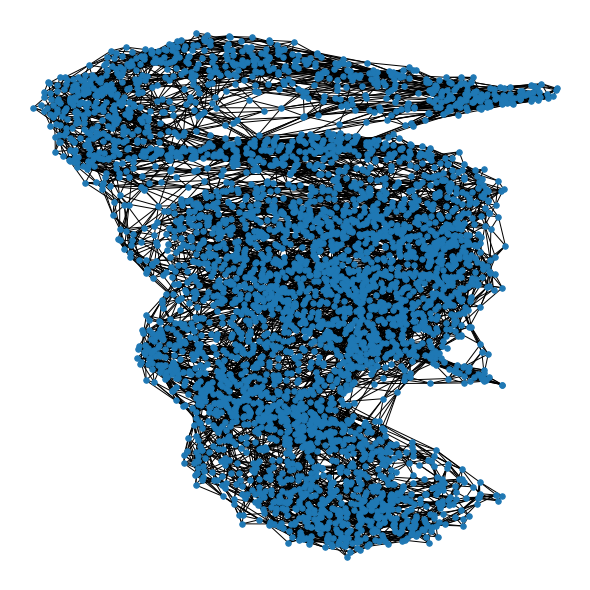

In [ ]:
# KNN-graph for the entire embedding space
fig = plt.figure(figsize=(8,8))
show_graph(A_word2vec)

In [ ]:
import itertools
test_embedding_w2vec_100 = dict(itertools.islice(test_embedding.items(),101))
test_word_labels_w2vec = make_label_dict(test_embedding_w2vec_100.keys())

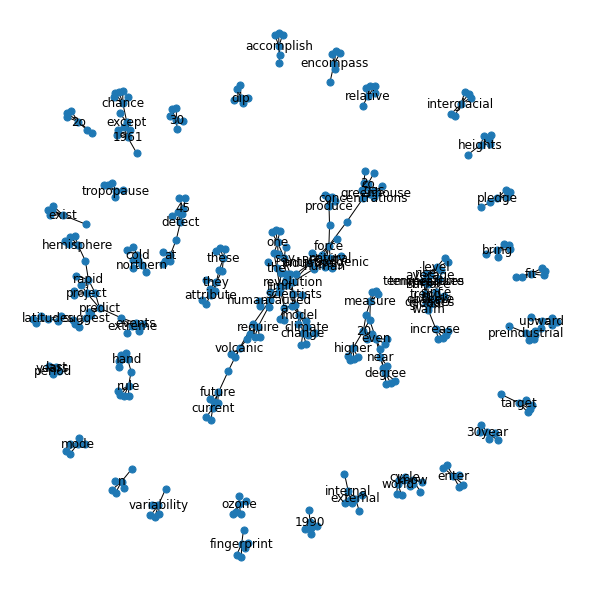

In [ ]:
# KNN-graph for a subset of the embeddings
fig = plt.figure(figsize=(8,8))
show_graph_with_labels(A_word2vec[:101], test_word_labels_w2vec)

From visualization of the KNN graph of w2vec embeddings for subset of words from test set:
- Words like 'greenhouse' and 'c02' appear closer in the w2vec embedding space.
- Words like 'external' and 'internal' which appear in similar context are together.
- we also notice similar context words like 'future' and 'cuurent' close to each other.
- generally north is associated with colder climate. We observe the words 'northern' and 'cold' appear together.
- we see opposite words like 'upward','increase' and 'dip' appear farther.


# **[CM2] Part1 : PCA** 

Applying PCA on the word2vec embeddings

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)

In [ ]:
pca.fit(list(train_embedding.values()))

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.transform(list(train_embedding.values()))

array([[ 3.87282085e+00,  4.20334800e-01,  2.51241054e+00, ...,
         3.31459410e-02,  1.90721085e-02,  3.25079002e-02],
       [ 3.55266811e+00,  6.63576282e-01,  1.79280519e+00, ...,
        -4.49735976e-02, -2.96195497e-03, -4.67219325e-02],
       [ 1.92313907e+00,  5.03022436e-01,  1.34305649e-01, ...,
        -1.34027107e-02,  3.70457042e-03, -1.28743264e-04],
       ...,
       [-3.17859052e-01,  3.86429627e-02,  1.28687361e-02, ...,
         3.62537639e-03,  3.30193574e-03,  8.36130100e-04],
       [-6.05596357e-01,  2.52565408e-02,  2.51138336e-02, ...,
        -2.40033980e-03,  2.28250228e-03, -3.28717325e-03],
       [-7.76470074e-01,  3.19532157e-02,  3.60747433e-02, ...,
         3.42901817e-03,  3.43810597e-03, -1.59703332e-03]])

In [ ]:
pca.explained_variance_ratio_

array([7.44995566e-01, 1.17617551e-01, 6.22416387e-02, 3.48808952e-02,
       2.22612852e-02, 5.48456242e-03, 3.10683831e-03, 2.78547588e-03,
       1.95629197e-03, 9.30024503e-04, 5.36743909e-04, 3.83045606e-04,
       3.67237162e-04, 3.44109180e-04, 2.34608930e-04, 1.94853058e-04,
       1.68563651e-04, 1.60019462e-04, 1.11111784e-04, 9.59998797e-05,
       8.22235834e-05, 6.76463519e-05, 6.12879647e-05, 5.35996697e-05,
       4.42476541e-05, 3.74946594e-05, 3.63574616e-05, 3.49072044e-05,
       3.13032872e-05, 2.84629138e-05])

### Scree plot 

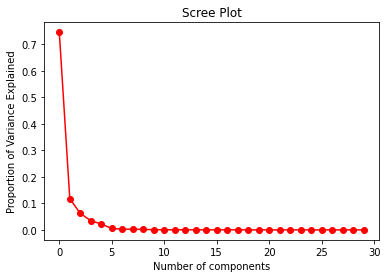

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(pca.explained_variance_ratio_,'ro-')
plt.title('Scree Plot')
plt.xlabel('Number of components')
plt.ylabel('Proportion of Variance Explained');

Principal components are formed in order of the proportion of variation they explain: PC1 captures the most variation, PC2 — the second most, and so on. Each of them contributes some information of the data, and in a PCA, there are as many principal components as there are characteristics. Leaving out PCs and we lose information.

A scree plot shows how much variation each PC captures from the data. The y axis is eigenvalues, which essentially stand for the proportion of variation explained and the number of componetnts in the x-axis. An ideal curve should be steep, then bends at an “elbow” — which is cutting-off point — and after that flattens out.

We observe a steep fall for n_component 1 with a sharp curve at 2 ,3 ,4 and then the curve flattens. In this case, we see the elbow of the scree plot at the fourth principle component. Also from the proportion of variance explained, we hold on to principal components that explain at least 95% of the variance cumulatively.  With the fourth principal component, the cumulative proportion of the variance explained surpasses 95%, therefore we would consider to keep four principal components.  If a higher threshold were used, then additional principal components would have to be retained.

### PCA Pair plot 

In [ ]:
# PCA with first 4 dimentionalities
pca = PCA(n_components=4, random_state = 0)

# fitting on the train set
pca.fit(list(train_embedding.values()))

PCA(copy=True, iterated_power='auto', n_components=4, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# transform on train set
pca_train = pca.transform(list(train_embedding.values()))

In [ ]:
# transform on test set
pca_test = pca.transform(list(test_embedding.values()))

In [ ]:
pca_test.shape

(3913, 4)

Text(0.5, 0.98, 'Pair plot of PCA first 4 components')

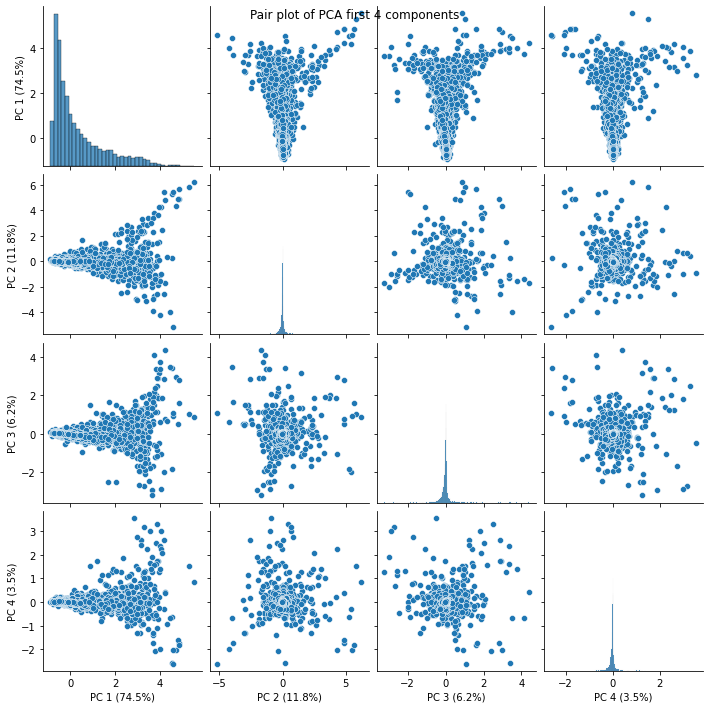

In [ ]:
import pandas as pd
import seaborn as sns

PC = []

for i, var in enumerate(pca.explained_variance_ratio_ * 100):
    PC.append(f"PC {i+1} ({var:.1f}%)")

a = sns.pairplot(pd.DataFrame(pca_test,
                columns = PC))
a.fig.suptitle("Pair plot of PCA first 4 components")

From the pair plot of the first four PCA dimensionalities, we observe:

- the principal components are orthagonal and there is no inter-dependence. In the graphs, the principal components are perpendicular to one another.
- We observe that most of the datapoints are distributed along the first Principle component. PC1 captures most variance i.e the most variant direction.
- It can be observed that  2nd(PC2) and 3rd(PC3) components are mostly zero until the 1st(PC1) component hits 4. This indicates that a lot of the points are on centred on the X axis in the embedding space.

In [ ]:
import numpy
# Calculates the cosine similarity between two arrays
def cos_similarity(A: numpy.ndarray, B: numpy.ndarray) -> float:
    dot_product = A.dot(B)
    norm_of_A = numpy.linalg.norm(A)
    norm_of_B = numpy.linalg.norm(B)
    cos = dot_product/(norm_of_A * norm_of_B)
    return cos

In [ ]:
# PCA with first 4 dimentionalities (as observed from scree plot)
pca = PCA(n_components=4, random_state = 0)

# fitting on the train set
pca.fit(list(train_embedding.values()))

# transform on test set
pca_test = pca.transform(list(test_embedding.values()))

In [ ]:
# creating PCA test embedding dataframe
test_embedding_df = pd.DataFrame(pca_test)
test_embedding_df["words"]=test_embedding.keys()

In [ ]:
test_embedding_df.head()

,0,1,2,3,words
0,3.223095,-0.598961,-0.652740,0.546134,the
1,2.956923,0.459381,-0.472731,-0.335042,world
2,0.370758,-0.122764,-0.065529,-0.097615,enter
3,3.085381,-1.300527,-0.006679,-0.105545,cold
4,0.941254,0.022955,-0.221132,-0.102709,mode


In [ ]:
# map of test_set words and their word vectors after pca
test_embedding_pca ={}
for key,i in zip(test_embedding.keys(),range(len(pca_test))):
    test_embedding_pca[key] = pca_test[i]

In [ ]:
for key, value in test_embedding_pca.items():
    print(key, ' : ', value)

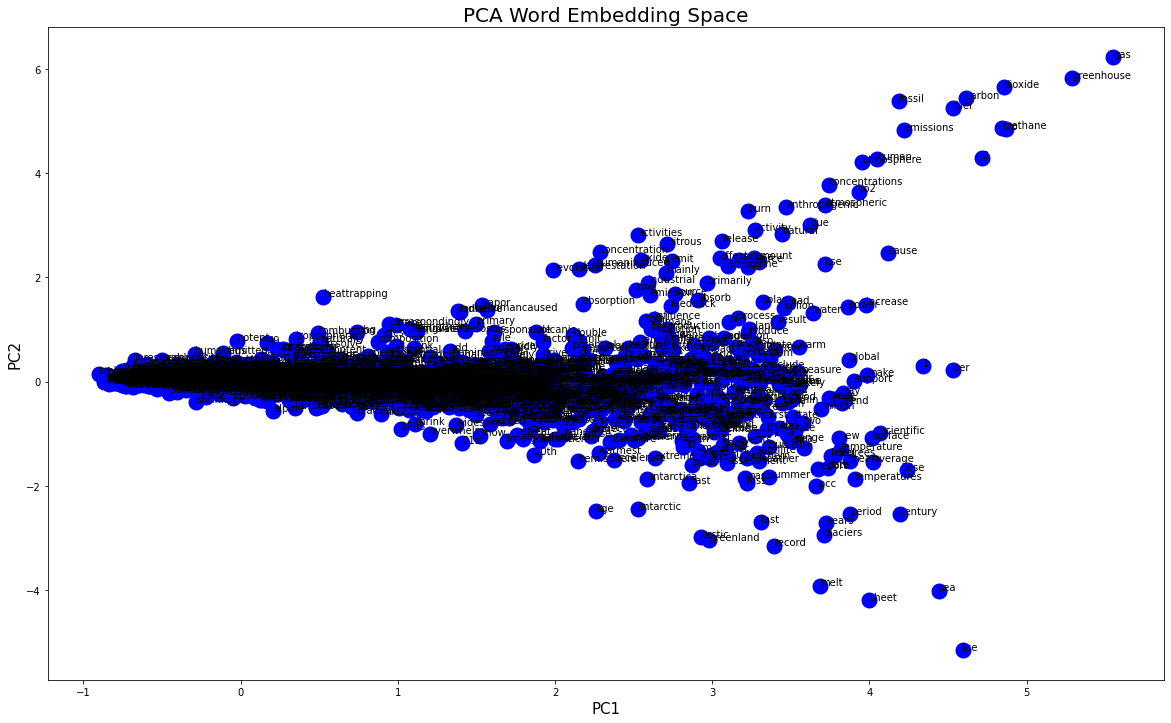

In [ ]:
# plotting first 2 PC dimentionalities
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.scatter(pca_test[:,0],pca_test[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("PCA Word Embedding Space",size=20)
for i, word in enumerate(list(test_embedding.keys())):
  plt.annotate(word,xy=(pca_test[i,0],pca_test[i,1]))

Visualizing the embedding space along the first 2 Principle components, we observe:
- similar words in the context of global warming like 'carbon', 'dioxide', 'greenhouse', 'methane' ,'CO' , 'emmission' etc. appear close to each other.

- Similarly words like 'ice' ,'melt' ,'sheet' ,'sea' ,'glaciers' , 'greenland', 'antartica' etc. which are all relevant in the context of glacial melt in Antarctica and Greenland and consequent rise in the sea/water level. The model is able to successfully identify words in similar concept as they appear frequently together. 

- We see that semantically dissimilar words like 'heat' , 'heattrapping' and 'ice' appear far from each other.

- we also observe words like 'industry' and 'deforestation' appear together. This is indication of the cause effect as formation of industries lead to increased deforestation.

**Comparison of PCA embeddings with Word2Vec embeddings**

In [ ]:
pca_test_df= pd.DataFrame(pca_test)

In [ ]:
# pair-wise cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
cos_sim_pca = cosine_similarity(pca_test_df.iloc[:,:].values, Y=None, dense_output=False)

In [ ]:
cos_df_pca = pd.DataFrame(cos_sim_pca, index = test_embedding_pca.keys(), columns = test_embedding_pca.keys()) 

Pair-wise cosine similarity: PCA

In [ ]:
cos_df_pca

,the,world,enter,cold,mode,likely,bring,global,dip,temperatures,last,20,30,years,say,one,target,suggest,limit,future,increase,mean,temperature,warm,2,relative,preindustrial,level,they,even,current,pledge,accomplish,chance,45,degree,rise,decades,greenhouse,gas,...,typical,λ,barrier,queensland,shark,drum,hook,kill,baby,stage,unfold,seabirds,wash,crescentic,1930s,postma,birth,climatology,automate,solution,apply,representation,try,experimental,theoretical,aside,wobble,henrik,svensmark,magnetic,deflect,nuclei,200year,component,reservoir,irregularly,periodic,subtropics,proper,heatwaves
the,1.000000,0.908707,0.910641,0.940426,0.943576,0.814226,0.964022,0.643137,-0.951620,0.686499,0.769663,0.853727,0.788252,0.786967,0.983279,0.987178,0.924547,0.994742,0.797670,0.879867,0.570835,0.687528,0.633371,0.677010,0.385427,0.891748,0.534190,0.503120,0.984371,0.892414,0.958130,0.967664,-0.971529,-0.998094,0.794945,0.956359,0.561486,0.776652,0.500921,0.492079,...,-0.936135,-0.969187,0.910597,-0.947916,-0.953806,-0.954035,-0.960007,0.939608,-0.958630,-0.960057,-0.952365,-0.958633,-0.948741,-0.958614,-0.945121,-0.955685,-0.970318,-0.957477,-0.957255,-0.980752,0.971188,-0.940837,0.940258,-0.952116,-0.937390,-0.965909,-0.962449,-0.908794,0.836321,0.930340,-0.962066,-0.963965,-0.962845,-0.791745,-0.952808,-0.951485,-0.909643,-0.963812,-0.961168,-0.713469
world,0.908707,1.000000,0.887724,0.838772,0.989298,0.729610,0.968779,0.539364,-0.987067,0.522573,0.534601,0.922776,0.703458,0.594346,0.947599,0.960894,0.997405,0.896098,0.910008,0.913760,0.632628,0.539560,0.514076,0.585284,0.680041,0.849511,0.595325,0.494343,0.917542,0.967831,0.923084,0.979822,-0.960200,-0.890682,0.910813,0.954041,0.494799,0.661432,0.702810,0.723395,...,-0.912929,-0.968243,0.873207,-0.974147,-0.971651,-0.972894,-0.952904,0.963306,-0.969457,-0.970305,-0.974869,-0.979924,-0.971256,-0.974715,-0.975930,-0.970722,-0.958549,-0.973471,-0.975368,-0.952169,0.979868,-0.962290,0.934959,-0.975885,-0.962413,-0.944845,-0.978260,-0.921423,0.839118,0.997324,-0.966403,-0.962967,-0.977560,-0.843254,-0.980579,-0.988353,-0.994670,-0.976891,-0.982604,-0.902158
enter,0.910641,0.887724,1.000000,0.961940,0.934427,0.632757,0.960747,0.386913,-0.920884,0.588935,0.721106,0.863901,0.822545,0.779918,0.903866,0.930010,0.913119,0.899356,0.691273,0.717102,0.432274,0.578978,0.537090,0.403311,0.410052,0.859899,0.549740,0.577292,0.875361,0.859868,0.809675,0.889633,-0.955190,-0.921435,0.794797,0.899632,0.562710,0.548370,0.312091,0.335949,...,-0.886936,-0.932745,0.993441,-0.916425,-0.926227,-0.924006,-0.902080,0.978600,-0.919611,-0.911282,-0.911425,-0.906012,-0.865202,-0.921040,-0.898370,-0.932441,-0.916044,-0.925694,-0.919635,-0.923459,0.934817,-0.877591,0.969885,-0.916490,-0.912347,-0.941351,-0.933424,-0.849104,0.872784,0.917116,-0.931374,-0.932725,-0.932997,-0.734976,-0.901855,-0.912137,-0.862743,-0.927138,-0.931666,-0.674697
cold,0.940426,0.838772,0.961940,1.000000,0.885966,0.780426,0.947190,0.579187,-0.908314,0.776436,0.878228,0.882531,0.920930,0.913304,0.889829,0.922182,0.874345,0.951300,0.716930,0.765161,0.557973,0.765547,0.723127,0.580706,0.373283,0.938021,0.654296,0.694134,0.928893,0.864353,0.863174,0.887239,-0.956006,-0.951898,0.807191,0.928676,0.716908,0.717151,0.316708,0.316173,...,-0.940925,-0.939455,0.942583,-0.921212,-0.931026,-0.928533,-0.931807,0.935809,-0.929937,-0.923592,-0.918091,-0.908620,-0.882242,-0.925483,-0.906081,-0.935745,-0.937830,-0.929517,-0.923731,-0.946448,0.912775,-0.901742,0.909735,-0.920367,-0.925991,-0.962440,-0.928356,-0.899593,0.757972,0.873976,-0.940272,-0.944278,-0.929077,-0.806585,-0.904477,-0.900442,-0.837295,-0.926769,-0.920986,-0.656603
mode,0.943576,0.989298,0.934427,0.885966,1.000000,0.707189,0.985814,0.498960,-0.987336,0.527360,0.587514,0.900177,0.720930,0.641876,0.974659,0.984064,0.992345,0.925576,0.852983,0.878185,0.555204,0.536603,0.499316,0.543606,0.573506,0.850298,0.541358,0.472091,0.931039,0.943581,0.918230,0.981863,-0.977859,-0.933622,0.868104,0.953276,0.477655,0.63931

In [ ]:
cos_sim_w2v = cosine_similarity(test_embedding_w2vec_df.iloc[:,:].values, Y=None, dense_output=False)

In [ ]:
cos_df_w2v = pd.DataFrame(cos_sim_w2v, index = test_embedding.keys(), columns = test_embedding.keys()) 

Pair-wise cosine similarity: Word2Vec

In [ ]:
cos_df_w2v

,the,world,enter,cold,mode,likely,bring,global,dip,temperatures,last,20,30,years,say,one,target,suggest,limit,future,increase,mean,temperature,warm,2,relative,preindustrial,level,they,even,current,pledge,accomplish,chance,45,degree,rise,decades,greenhouse,gas,...,typical,λ,barrier,queensland,shark,drum,hook,kill,baby,stage,unfold,seabirds,wash,crescentic,1930s,postma,birth,climatology,automate,solution,apply,representation,try,experimental,theoretical,aside,wobble,henrik,svensmark,magnetic,deflect,nuclei,200year,component,reservoir,irregularly,periodic,subtropics,proper,heatwaves
the,1.000000,0.937338,0.968786,0.952239,0.960934,0.837255,0.971266,0.720247,0.715307,0.750671,0.744719,0.884369,0.821662,0.731994,0.977662,0.974634,0.947227,0.990494,0.875383,0.925779,0.673646,0.747220,0.705202,0.753708,0.461802,0.928341,0.698303,0.597097,0.981432,0.924222,0.972921,0.965740,0.950678,0.942545,0.871414,0.957533,0.635585,0.824041,0.590267,0.585083,...,0.965016,0.909956,0.947795,0.970434,0.971101,0.972421,0.957405,0.944110,0.934453,0.960910,0.967745,0.949924,0.966876,0.871708,0.963741,0.971971,0.964282,0.943270,0.953505,0.909303,0.971124,0.968107,0.970604,0.970604,0.971410,0.962621,0.953635,0.966848,0.967817,0.957765,0.966007,0.956098,0.958722,0.971608,0.966586,0.957003,0.972193,0.940187,0.959345,0.971963
world,0.937338,1.000000,0.967958,0.893898,0.986443,0.784904,0.976682,0.642625,0.557467,0.637502,0.609252,0.934028,0.779456,0.629964,0.955126,0.964665,0.988085,0.932344,0.942993,0.942923,0.719382,0.652208,0.634266,0.687365,0.672245,0.911857,0.742408,0.576795,0.953722,0.973365,0.947418,0.978596,0.978520,0.979949,0.936410,0.963403,0.579887,0.744503,0.727036,0.746352,...,0.986459,0.960566,0.940551,0.968784,0.974561,0.968697,0.982109,0.966355,0.954245,0.974542,0.972136,0.950466,0.971149,0.858420,0.955052,0.975007,0.982292,0.939729,0.946317,0.980312,0.980833,0.974802,0.978598,0.966399,0.970495,0.985497,0.951643,0.978777,0.979502,0.986024,0.982035,0.983661,0.964075,0.981030,0.965127,0.942887,0.934128,0.941228,0.961900,0.965301
enter,0.968786,0.967958,1.000000,0.971733,0.989063,0.814853,0.997320,0.648694,0.705746,0.733730,0.744664,0.947454,0.874623,0.759276,0.965545,0.980053,0.982857,0.972058,0.900244,0.907244,0.689132,0.732589,0.702189,0.678809,0.582701,0.954876,0.772868,0.658952,0.975102,0.965136,0.945257,0.986193,0.978845,0.983040,0.933808,0.978377,0.665384,0.770829,0.585140,0.598058,...,0.989255,0.959925,0.985998,0.986461,0.988479,0.985847,0.991897,0.989527,0.969651,0.992862,0.992326,0.989295,0.997183,0.909250,0.990255,0.981095,0.992739,0.960598,0.982020,0.970510,0.990571,0.995235,0.994848,0.991740,0.984491,0.986705,0.971254,0.992253,0.992241,0.988422,0.990344,0.983817,0.984128,0.993113,0.994465,0.984662,0.986972,0.972888,0.985430,0.990646
cold,0.952239,0.893898,0.971733,1.000000,0.937119,0.825729,0.963222,0.667597,0.827435,0.817649,0.851302,0.911639,0.923114,0.852773,0.921143,0.943610,0.923115,0.963749,0.825637,0.845974,0.666847,0.806500,0.775264,0.686140,0.462534,0.950924,0.772625,0.702000,0.953585,0.911145,0.905768,0.943974,0.931394,0.934049,0.882444,0.948093,0.724773,0.790281,0.449296,0.446596,...,0.937028,0.904303,0.967289,0.960256,0.949934,0.949146,0.945768,0.952644,0.926033,0.954567,0.962053,0.968914,0.967694,0.898839,0.969564,0.935944,0.950197,0.924652,0.957159,0.903374,0.946882,0.958744,0.955457,0.962853,0.942577,0.935291,0.949067,0.951312,0.950584,0.940069,0.947554,0.929622,0.953053,0.954996,0.970062,0.976259,0.987471,0.949144,0.958023,0.967983
mode,0.960934,0.986443,0.989063,0.937119,1.000000,0.815511,0.994898,0.645639,0.639421,0.680320,0.696220,0.946664,0.833625,0.716002,0.980934,0.990217,0.996135,0.965333,0.926965,0.929087,0.692370,0.687846,0.656253,0.685762,0.629249,0.939075,0.750445,0.591573,0.975479,0.975027,0.953874,0.994190,0.989652,0.989300,0.943548,0.981621,0.601495,0.766836,0.657106,0.671928,...,0.997048,0.974734,0.975134,0.986581,0.992044,0.987871,0.996686,0.991743,0.976842,0.993649,0.991556,0.978942,0.989688,0.897906,0

From the above 2 dataframes of pair-wise cosine similarities, we can observe the cosine similarity values of each word in the test set and every other word in the set in the PCA and word2vec embedding space.

- we observe negative cosine similarities in PCA subspace. This could be attributed to centering of data during PCA application.

- considering the absolute cosine similarities, we notice the cosine similarities are higher in the word2vec embedding space compared to the PCA embedding space. For instance considering the words 'world' & cold' :

  PCA cosine similarity : 0.838772

  Word2vec cosine similarity : 0.893898

In [ ]:
with open('test_embedding_pca.txt', 'w', encoding="utf-8") as f: 
    f.write('%s %s\n' % (len(test_embedding_pca.keys()), 4))
    for key, value in test_embedding_pca.items():
        f.write('%s %s %s %s %s\n' % (key, value[0],value[1],value[2],value[3]))

In [ ]:
pca_model = gensim.models.KeyedVectors.load_word2vec_format('test_embedding_pca.txt', binary=False)

Comparing cosine similarities of few signifant/important words:

In [ ]:
# pca model
pca_model.most_similar('carbon',topn=5)

[('dioxide', 0.9959695339202881),
 ('correspondingly', 0.9943975210189819),
 ('methane', 0.9942948818206787),
 ('content', 0.9927193522453308),
 ('nitrous', 0.9893808364868164)]

In [ ]:
# w2vec model
model.most_similar('carbon',topn=5)

[('methane', 0.9804165363311768),
 ('chlorofluorocarbons', 0.9779826402664185),
 ('dioxide', 0.9746006727218628),
 ('nitrous', 0.9659712314605713),
 ('96', 0.9649980068206787)]

We see the word 'carbon' is most similar to 'dioxide' in the PCA subspace whereas similar to 'methane' in the word2vec subspace.
Similarly considering the cosine similarities for 'carbon' & 'dioxide':

PCA subspace : 0.9959695339202881

Word2vec subspace : 0.9746006727218628

In both the subspace, the most similar words appear in similar context as both 'dioxide' and 'methane' are relevant to 'carbon'

In [ ]:
# pca model
pca_model.most_similar('glaciers',topn=5)

[('antarctica', 0.9976590871810913),
 ('antarctic', 0.9949178099632263),
 ('dramatic', 0.994631826877594),
 ('bottom', 0.9943311214447021),
 ('greenland', 0.9923969507217407)]

In [ ]:
# w2vec model
model.most_similar('glaciers',topn=5)

[('antarctic', 0.9970004558563232),
 ('greenland', 0.9952079653739929),
 ('loss', 0.988825798034668),
 ('antarctica', 0.9882369637489319),
 ('sheet', 0.9868824481964111)]

Considering the word 'glaciers', we see both the models identify similar context words 'antarica'/'antarctic' with relatively similar cosine similarity.

PCA : 0.9976590871810913

Word2vec: 0.9970004558563232

Similarly considering the context word 'greenland':

PCA: 0.9923969507217407

Word2vec: 0.9952079653739929

But we also notice words like 'dramatic' and 'bottom' in the PCA subspace which aren't essentially relevant to 'glaciers'

In [ ]:
# pca model
pca_model.most_similar('june',topn=5)

[('october', 0.9998493790626526),
 ('extend', 0.9997817277908325),
 ('2003', 0.9995821118354797),
 ('sit', 0.9992489814758301),
 ('america', 0.9992311000823975)]

In [ ]:
# w2vec model
model.most_similar('june',topn=5)

[('july', 0.9989757537841797),
 ('january', 0.9989748001098633),
 ('confirm', 0.9987897276878357),
 ('april', 0.9987339973449707),
 ('october', 0.9985716342926025)]

Considering the word 'june' , we observe the cosine similarities in Word2vec subspace show similar moth words like 'july', 'january', 'april' etc, in the PCA subspace other than 'october' we see out of context words like 'sit', 'america' etc.
 Considering 'june' and 'october':
 
PCA : 0.9998493790626526

Word2vec : 0.9985716342926025

**KNN graph for PCA**

Applying KNN-graph over the PCA test embeddings with 5 nearest neighbours.

In [ ]:
A_pca = kneighbors_graph(pca_test_df, 5)

In [ ]:
A_pca.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We obtain the adjacency matrix, which has the value 1 for the 5 closest neighbours of each word and 0 for every other datapoint.

Comparing the adjacency matrix for the word2vec embeddings and the the PCA emeddings for the test set, we obtain the f1_score of the embeddings indicating the extent of similarity between them. 

The f1-score is particularly useful in this case when the class distubution is uneven. It specifies on average what percent of neighbors for each word are same in word2vec embeddings and pca embedding.

In [ ]:
A_pca = A_pca.toarray()

In [ ]:
row,column= A_pca.shape

In [ ]:
from sklearn.metrics import f1_score

f1_score_pca_sum =0

for i in range(column):
  f1_score_pca_sum = f1_score_pca_sum + f1_score(A_word2vec[:,i], A_pca[:,i])
f1_score_pca = f1_score_pca_sum/column

In [ ]:
f1_score_pca

0.590302227153497

On comparing the KNN-graphs (sparce matrix) columnwise, we conpute the average f1_scoe for the PCA and the Word2vec test embedding.
We observe that 59% of the neighbours of each word in the word2vec embeddings space are same as neighbours in the PCA embedding space.
Thus PCA is able to maintain the semantic similarity of the word vectors.

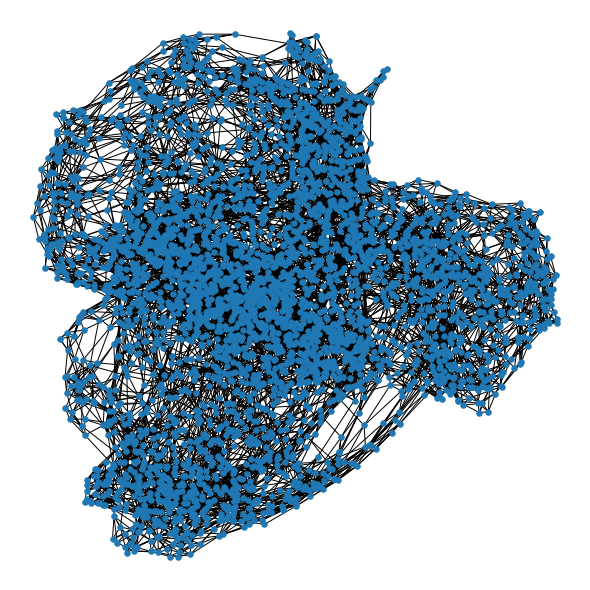

In [ ]:
fig = plt.figure(figsize=(8,8))
show_graph(A_pca)

In [ ]:
test_embedding_pca_100 = dict(itertools.islice(test_embedding_pca.items(),101))
test_word_labels_pca = make_label_dict(test_embedding_pca_100.keys())

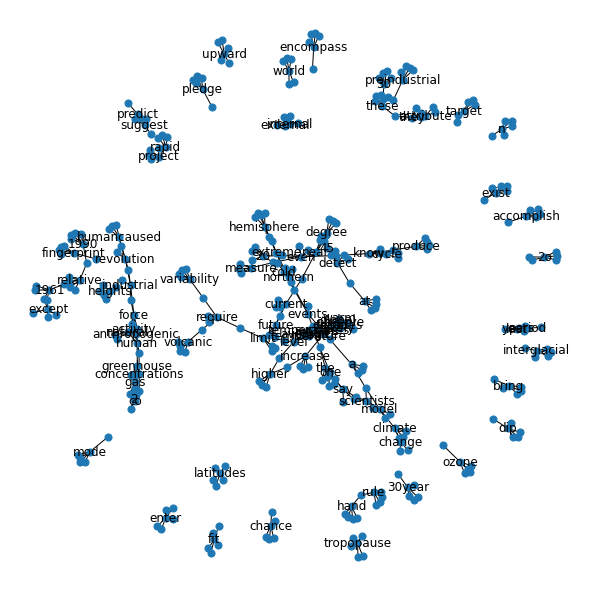

In [ ]:
fig = plt.figure(figsize=(8,8))
show_graph_with_labels(A_pca[:101], test_word_labels_pca)

From visualization of the KNN graph of PCA embeddings for subset of words from test set:
- Words like 'climate' and 'change' appear closer as was the case in w2vec embeddings.
- Words like 'greenhouse', 'co2', 'gas' appear closer in the PCA embedding space. This is similar to what we observed in the word2vec subspace.
- Words like 'external' and 'internal' which appear in similar context are overlapping.
- We observe the words 'northern' and 'cold' appear together. This is similar to what we observed in the word2vec subspace.
- we see opposite words like 'upward','increase' and 'dip' appear farther in the PCA embedding space.
- In general, visually comparing the Word2vec KNN-Graph and the PCA KNN-Graph, we see the in the PCA, the distance between the nearest neighbours is reduced and they appear overlapping to each other, which is not the case in word2vec.

# **CM3: Part2 : LLE**

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

# apply LLE on word2vec test embeddings with embedding dimentionality 4
lle = LocallyLinearEmbedding(n_components=4, random_state=0)  
lle_test = lle.fit_transform(list(test_embedding.values()))

### LLE Pair-plot

Text(0.5, 0.98, 'Pair plot of LLE first 4 components')

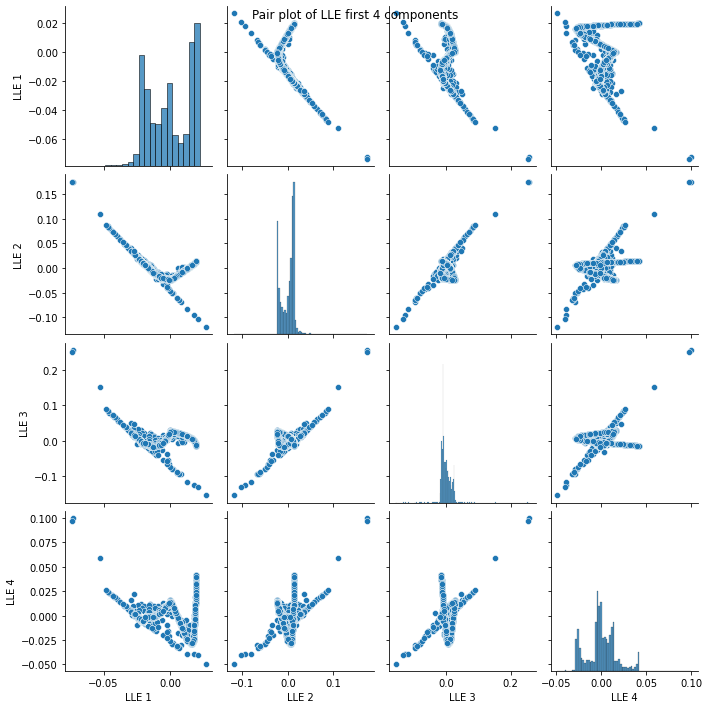

In [ ]:
# visualize the first four dimensionalities of this subspace using a pairs plot
LLE = ['LLE 1','LLE 2','LLE 3','LLE 4']
a = sns.pairplot(pd.DataFrame(lle_test,
                columns = LLE))
a.fig.suptitle("Pair plot of LLE first 4 components")

LLE first finds the k-nearest neighbors of the points and approximates each data vector as a weighted linear combination of its k-nearest neighbors. It computes the weights that best reconstruct the vectors from its neighbors, then produce the low-dimensional vectors best reconstructed by these weights.

From the pair plot of the first four LLE dimensionalities, we observe:
- The manifold for the distribution form a specific linear shape. This is consistent across all 4 LLE dimensions.
- the LLE1 seems to be inversely coorelated with LLE 2, 3 and 4.
- whereas the other dimensions LLE 2, 3 & 4 are positively correlated to each other
- LLE tries to preserve the geometric features of the original non-linear feature structure

**Comparison of LLE embeddings with Word2Vec embeddings**

In [ ]:
# map of test_set words and their word vectors after lle
test_embedding_lle = {}
for key, i in zip(test_embedding.keys(), range(len(lle_test))):
    test_embedding_lle[key] = lle_test[i]

In [ ]:
lle_test_df = pd.DataFrame(lle_test)
cos_sim_lle = cosine_similarity(lle_test_df.iloc[:,:].values, Y=None, dense_output=False)
cos_df_lle = pd.DataFrame(cos_sim_lle, index = test_embedding_lle.keys(), columns = test_embedding_lle.keys()) 

Pair-wise cosine similarity: LLE

In [ ]:
cos_df_lle

,the,world,enter,cold,mode,likely,bring,global,dip,temperatures,last,20,30,years,say,one,target,suggest,limit,future,increase,mean,temperature,warm,2,relative,preindustrial,level,they,even,current,pledge,accomplish,chance,45,degree,rise,decades,greenhouse,gas,...,typical,λ,barrier,queensland,shark,drum,hook,kill,baby,stage,unfold,seabirds,wash,crescentic,1930s,postma,birth,climatology,automate,solution,apply,representation,try,experimental,theoretical,aside,wobble,henrik,svensmark,magnetic,deflect,nuclei,200year,component,reservoir,irregularly,periodic,subtropics,proper,heatwaves
the,1.000000,0.969541,0.074335,0.741747,0.890736,0.993824,0.927496,0.992644,-0.262371,0.988154,0.606086,0.999243,0.941403,0.665456,0.997343,0.997415,0.914698,0.933911,0.957812,0.959664,0.803165,0.987540,0.986923,0.992669,0.698350,0.924461,0.997737,0.900318,0.919741,0.987874,0.965627,-0.175847,-0.287717,-0.436392,0.881777,0.985629,0.926774,0.992304,0.472986,0.435967,...,-0.424544,-0.338567,0.866286,-0.188414,-0.184647,-0.379837,-0.274595,0.935051,-0.310925,-0.183025,-0.182799,-0.247008,-0.475091,-0.256550,-0.189511,-0.376543,-0.434333,-0.260730,-0.330344,-0.267400,0.875238,-0.465732,-0.236149,-0.195060,-0.188870,-0.453210,-0.323171,-0.435817,-0.347777,0.231683,-0.253554,-0.197101,-0.324104,-0.466058,-0.189863,-0.188364,-0.265418,-0.282073,-0.182722,-0.458161
world,0.969541,1.000000,0.280376,0.554983,0.959242,0.936573,0.990432,0.933042,-0.309887,0.920634,0.399542,0.978208,0.830126,0.465518,0.984807,0.984605,0.983081,0.992977,0.997948,0.997890,0.632808,0.919072,0.917525,0.933113,0.596762,0.988882,0.982955,0.766346,0.986201,0.995713,0.999227,0.013686,-0.317280,-0.541661,0.965147,0.996507,0.806564,0.932059,0.316060,0.274191,...,-0.540159,-0.376833,0.956721,-0.170852,-0.167950,-0.406091,-0.300618,0.993114,-0.353484,-0.171258,-0.167810,-0.235329,-0.589314,-0.304450,-0.171671,-0.405195,-0.550665,-0.308350,-0.369817,-0.259257,0.948515,-0.581817,-0.053809,-0.177248,-0.180332,-0.569976,-0.364132,-0.540673,-0.209883,0.441834,-0.275303,-0.180112,-0.325152,-0.519753,-0.181511,-0.173012,-0.286919,-0.327968,-0.169072,-0.531707
enter,0.074335,0.280376,1.000000,-0.526115,0.512658,-0.012937,0.401402,-0.019470,-0.155486,-0.049000,-0.510723,0.110101,-0.219006,-0.510783,0.136364,0.133160,0.447351,0.379316,0.337622,0.334990,-0.444807,-0.052583,-0.056117,-0.019351,0.095352,0.414794,0.139056,-0.309813,0.430975,0.210699,0.309906,0.955353,-0.478188,-0.108056,0.520719,0.227796,-0.254133,-0.021317,-0.125861,-0.147706,...,-0.162414,-0.322299,0.544204,-0.454652,-0.450853,-0.469082,-0.474118,0.383338,-0.255319,-0.445552,-0.448081,-0.504029,-0.287839,-0.144556,-0.455729,-0.447362,-0.184142,-0.152401,-0.301665,-0.519965,0.540300,-0.265331,0.930492,-0.460723,-0.447749,-0.229182,-0.283470,-0.104264,0.813819,0.977647,-0.464801,-0.462783,-0.545979,0.125704,-0.448416,-0.453866,-0.474136,-0.193928,-0.446946,0.038208
cold,0.741747,0.554983,-0.526115,1.000000,0.393587,0.810736,0.437641,0.816309,-0.053143,0.835073,0.961034,0.715313,0.924444,0.983217,0.690935,0.691843,0.412901,0.452954,0.519640,0.526011,0.995003,0.837272,0.839418,0.816201,0.725760,0.431204,0.696858,0.959707,0.421987,0.628698,0.543013,-0.647445,-0.088981,-0.009654,0.349202,0.618571,0.939328,0.817825,0.728489,0.717332,...,0.027505,-0.120578,0.319441,-0.149383,-0.144494,-0.171460,-0.089674,0.456068,-0.094111,-0.130020,-0.138603,-0.172822,-0.003036,-0.048708,-0.150887,-0.164329,0.024012,-0.051907,-0.112943,-0.177000,0.369703,0.006799,-0.667793,-0.154531,-0.125155,0.014976,-0.105147,-0.010536,-0.621365,-0.431562,-0.087176,-0.153615,-0.192015,-0.173166,-0.125305,-0.143268,-0.095504,-0.068886,-0.134912,-0.112658
mode,0.890736,0.959242,0.512658,0.393587,1.000000,0.844958,0.979342,0.840928,-0.226742,0.823556,0.274162,0.906511,0.705755,0.328203,0.916942,0.915473,0.990106,0.974242,0.975168,0.974745,0.482920,0.821394,0.819246,0.841003,0.618642,0.982673,0.918592,0.628936,0.986725,0.942997,0.968708,0.270427,-0.508525,-0.466579,0.993566,0.949

Pir-wise cosine similarity: Word2vec

In [ ]:
cos_df_w2v

,the,world,enter,cold,mode,likely,bring,global,dip,temperatures,last,20,30,years,say,one,target,suggest,limit,future,increase,mean,temperature,warm,2,relative,preindustrial,level,they,even,current,pledge,accomplish,chance,45,degree,rise,decades,greenhouse,gas,...,typical,λ,barrier,queensland,shark,drum,hook,kill,baby,stage,unfold,seabirds,wash,crescentic,1930s,postma,birth,climatology,automate,solution,apply,representation,try,experimental,theoretical,aside,wobble,henrik,svensmark,magnetic,deflect,nuclei,200year,component,reservoir,irregularly,periodic,subtropics,proper,heatwaves
the,1.000000,0.937338,0.968786,0.952239,0.960934,0.837255,0.971266,0.720247,0.715307,0.750671,0.744719,0.884369,0.821662,0.731994,0.977662,0.974634,0.947227,0.990494,0.875383,0.925779,0.673646,0.747220,0.705202,0.753708,0.461802,0.928341,0.698303,0.597097,0.981432,0.924222,0.972921,0.965740,0.950678,0.942545,0.871414,0.957533,0.635585,0.824041,0.590267,0.585083,...,0.965016,0.909956,0.947795,0.970434,0.971101,0.972421,0.957405,0.944110,0.934453,0.960910,0.967745,0.949924,0.966876,0.871708,0.963741,0.971971,0.964282,0.943270,0.953505,0.909303,0.971124,0.968107,0.970604,0.970604,0.971410,0.962621,0.953635,0.966848,0.967817,0.957765,0.966007,0.956098,0.958722,0.971608,0.966586,0.957003,0.972193,0.940187,0.959345,0.971963
world,0.937338,1.000000,0.967958,0.893898,0.986443,0.784904,0.976682,0.642625,0.557467,0.637502,0.609252,0.934028,0.779456,0.629964,0.955126,0.964665,0.988085,0.932344,0.942993,0.942923,0.719382,0.652208,0.634266,0.687365,0.672245,0.911857,0.742408,0.576795,0.953722,0.973365,0.947418,0.978596,0.978520,0.979949,0.936410,0.963403,0.579887,0.744503,0.727036,0.746352,...,0.986459,0.960566,0.940551,0.968784,0.974561,0.968697,0.982109,0.966355,0.954245,0.974542,0.972136,0.950466,0.971149,0.858420,0.955052,0.975007,0.982292,0.939729,0.946317,0.980312,0.980833,0.974802,0.978598,0.966399,0.970495,0.985497,0.951643,0.978777,0.979502,0.986024,0.982035,0.983661,0.964075,0.981030,0.965127,0.942887,0.934128,0.941228,0.961900,0.965301
enter,0.968786,0.967958,1.000000,0.971733,0.989063,0.814853,0.997320,0.648694,0.705746,0.733730,0.744664,0.947454,0.874623,0.759276,0.965545,0.980053,0.982857,0.972058,0.900244,0.907244,0.689132,0.732589,0.702189,0.678809,0.582701,0.954876,0.772868,0.658952,0.975102,0.965136,0.945257,0.986193,0.978845,0.983040,0.933808,0.978377,0.665384,0.770829,0.585140,0.598058,...,0.989255,0.959925,0.985998,0.986461,0.988479,0.985847,0.991897,0.989527,0.969651,0.992862,0.992326,0.989295,0.997183,0.909250,0.990255,0.981095,0.992739,0.960598,0.982020,0.970510,0.990571,0.995235,0.994848,0.991740,0.984491,0.986705,0.971254,0.992253,0.992241,0.988422,0.990344,0.983817,0.984128,0.993113,0.994465,0.984662,0.986972,0.972888,0.985430,0.990646
cold,0.952239,0.893898,0.971733,1.000000,0.937119,0.825729,0.963222,0.667597,0.827435,0.817649,0.851302,0.911639,0.923114,0.852773,0.921143,0.943610,0.923115,0.963749,0.825637,0.845974,0.666847,0.806500,0.775264,0.686140,0.462534,0.950924,0.772625,0.702000,0.953585,0.911145,0.905768,0.943974,0.931394,0.934049,0.882444,0.948093,0.724773,0.790281,0.449296,0.446596,...,0.937028,0.904303,0.967289,0.960256,0.949934,0.949146,0.945768,0.952644,0.926033,0.954567,0.962053,0.968914,0.967694,0.898839,0.969564,0.935944,0.950197,0.924652,0.957159,0.903374,0.946882,0.958744,0.955457,0.962853,0.942577,0.935291,0.949067,0.951312,0.950584,0.940069,0.947554,0.929622,0.953053,0.954996,0.970062,0.976259,0.987471,0.949144,0.958023,0.967983
mode,0.960934,0.986443,0.989063,0.937119,1.000000,0.815511,0.994898,0.645639,0.639421,0.680320,0.696220,0.946664,0.833625,0.716002,0.980934,0.990217,0.996135,0.965333,0.926965,0.929087,0.692370,0.687846,0.656253,0.685762,0.629249,0.939075,0.750445,0.591573,0.975479,0.975027,0.953874,0.994190,0.989652,0.989300,0.943548,0.981621,0.601495,0.766836,0.657106,0.671928,...,0.997048,0.974734,0.975134,0.986581,0.992044,0.987871,0.996686,0.991743,0.976842,0.993649,0.991556,0.978942,0.989688,0.897906,0

From the above 2 dataframes of pair-wise cosine similarities, we can observe the cosine similarity values of each word in the test set and every other word in the set in the LLE and word2vec embedding space.

- Considering the absolute cosine similarities, we notice the cosine similarities are higher in the word2vec embedding space compared to the LLE embedding space. For instance considering the words 'world' & cold':

  LLE cosine similarity : 0.554983

  Word2vec cosine similarity : 0.893898

In [ ]:
with open('test_embedding_lle.txt', 'w', encoding="utf-8") as f: 
    f.write('%s %s\n' % (len(test_embedding_lle.keys()), 4))
    for key, value in test_embedding_lle.items():
        f.write('%s %s %s %s %s\n' % (key, value[0],value[1],value[2],value[3]))

In [ ]:
lle_model = gensim.models.KeyedVectors.load_word2vec_format('test_embedding_lle.txt', binary=False)

In [ ]:
lle_model.most_similar('carbon')

[('methane', 0.9999682903289795),
 ('dioxide', 0.9995670318603516),
 ('greenhouse', 0.9947207570075989),
 ('activities', 0.9936545491218567),
 ('co', 0.9923534393310547),
 ('humaninduced', 0.99137282371521),
 ('emissions', 0.9912731051445007),
 ('gas', 0.9896917939186096),
 ('absence', 0.9876093864440918),
 ('21st', 0.9762848615646362)]

In [ ]:
model.most_similar('carbon')

[('methane', 0.9804165363311768),
 ('chlorofluorocarbons', 0.9779826402664185),
 ('dioxide', 0.9746006727218628),
 ('nitrous', 0.9659712314605713),
 ('96', 0.9649980068206787),
 ('tropospheric', 0.9622126817703247),
 ('49', 0.9581986665725708),
 ('nonco2', 0.9581005573272705),
 ('oxide', 0.9576266407966614),
 ('release', 0.9563332200050354)]

We see the word 'carbon' is most similar to 'methane' in the LLE subspace and  in the word2vec subspace. Similarly considering the cosine similarities for 'carbon' & 'dioxide':

LLE subspace : 0.9995670318603516

Word2vec subspace : 0.9746006727218628

In both the subspace, the most similar words appear in similar context as both 'dioxide' and 'methane' are relevant to 'carbon'

In [ ]:
lle_model.most_similar('glaciers')

[('polar', 0.9999985098838806),
 ('rat', 0.9999204874038696),
 ('sheet', 0.9998705387115479),
 ('melt', 0.9997907876968384),
 ('west', 0.9995099306106567),
 ('mass', 0.9994706511497498),
 ('lose', 0.9992210865020752),
 ('ice', 0.9992193579673767),
 ('greenland', 0.9987722039222717),
 ('cover', 0.9987517595291138)]

In [ ]:
model.most_similar('glaciers')

[('antarctic', 0.9970004558563232),
 ('greenland', 0.9952079653739929),
 ('loss', 0.988825798034668),
 ('antarctica', 0.9882369637489319),
 ('sheet', 0.9868824481964111),
 ('alpine', 0.9844338297843933),
 ('shrinkage', 0.9840260148048401),
 ('snow', 0.9806098341941833),
 ('landbased', 0.9798789024353027),
 ('mass', 0.9784616231918335)]

Considering the word 'glacier', we see both the models identify similar context words 'greenland' and 'sheet'. For the word 'sheet',

LLE : 0.9998705387115479

Word2vec: 0.9868824481964111

Similarly considering the context word 'greenland':

LLE: 0.9987722039222717

Word2vec: 0.9952079653739929

In [ ]:
lle_model.most_similar('june')

[('fact', 0.9999924302101135),
 ('december', 0.9999922513961792),
 ('write', 0.9999914169311523),
 ('on', 0.9999827146530151),
 ('6', 0.9999823570251465),
 ('august', 0.999946653842926),
 ('observations', 0.999942421913147),
 ('2008', 0.9999364614486694),
 ('suggest', 0.9999234676361084),
 ('2018', 0.9999197721481323)]

In [ ]:
lle_model.similarity("june","july")

0.982526

In [ ]:
model.most_similar('june')

[('july', 0.9989757537841797),
 ('january', 0.9989748001098633),
 ('confirm', 0.9987897276878357),
 ('april', 0.9987339973449707),
 ('october', 0.9985716342926025),
 ('1988', 0.9983054399490356),
 ('august', 0.9980118870735168),
 ('february', 0.9979966282844543),
 ('december', 0.9978994727134705),
 ('seven', 0.9976174831390381)]

For the word 'june', we observe that LLE model doesn't identify the context words efficienty as we obtain many out of context words as similar words like 'write', 'fact', 'suggest'. While W2vec model identifies similar words  in the right context (month words) such as 'july', 'january', 'december'.  

Considering the words 'june' and 'july', we observe a higher cos similarity in Word2vec subspace than LLE:

LLE cosine similarity: 0.982526

Word2vec cosine similarity: 0.9989757537841797


**KNN graph for LLE**

In [ ]:
from sklearn.neighbors import kneighbors_graph
A_lle = kneighbors_graph(lle_test_df, 5)

In [ ]:
A_lle.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We obtain the adjacency matrix, which has the value 1 for the 5 closest neighbours of each word and 0 for every other datapoint.

Comparing the adjacency matrix for the word2vec embeddings and the the LLE emeddings for the test set, we obtain the f1_score of the embeddings indicating the extent of similarity between them. 

The f1-score is particularly useful in this case when the class distubution is uneven. It specifies on average what percent of neighbors for each word are same in word2vec embeddings and LLE embeddings.

In [ ]:
A_lle = A_lle.toarray()

In [ ]:
row,column= A_lle.shape

In [ ]:
f1_score_lle_sum =0

for i in range(column):
  f1_score_lle_sum = f1_score_lle_sum + f1_score(A_word2vec[:,i], A_lle[:,i])
f1_score_lle = f1_score_lle_sum/column

In [ ]:
f1_score_lle

0.1253260163010702

On comparing the KNN-graphs (sparce matrix) columnwise, we compute the average f1_score for the LLE and the Word2vec test embedding.
We observe that only 12% of the neighbours of each word in the word2vec embeddings space are same as neighbours in the LLE embedding space.
Thus LLE is able to maintain the semantic similarity in global context of the word vectors only to small extent . Since LLE is based on local piece-wise embeddings, it doesn't retain the global context.

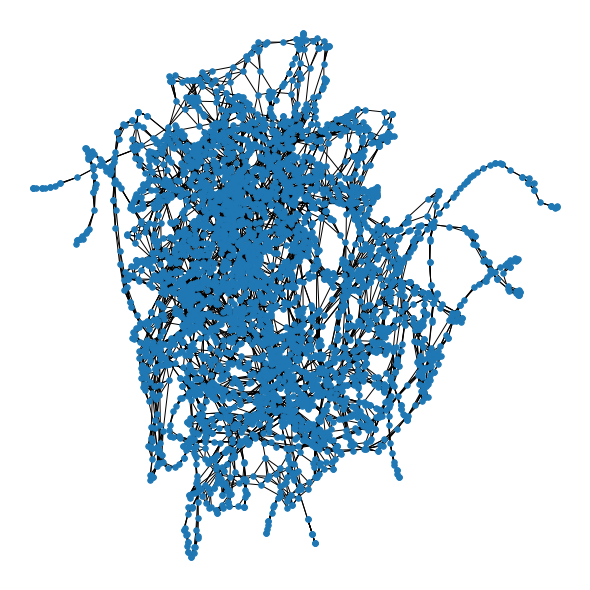

In [ ]:
fig = plt.figure(figsize=(8,8))
show_graph(A_lle)

In [ ]:
test_embedding_lle_100 = dict(itertools.islice(test_embedding_lle.items(),101))
test_word_labels_lle = make_label_dict(test_embedding_lle_100.keys())

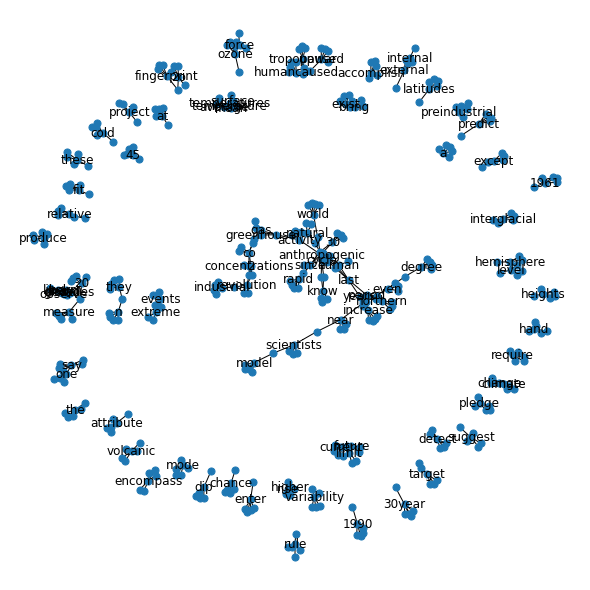

In [ ]:
fig = plt.figure(figsize=(8,8))
show_graph_with_labels(A_lle[:101], test_word_labels_lle)

From visualization of KNN graph of LLE embeddings for subset of words from test set, we observe that the semantic relations between words is preserved in the LLE subspace:
- Words like 'climate' and 'change' appear closer as was the case in w2vec embeddings
- Words like 'greenhouse' and 'c02' appear closer as was the case in w2vec embeddings.
- Words like 'external' and 'internal' which appear in similar context are together as was the case with w2vec embeddings.
- We also notice similar context words like 'future' and 'current' close to each other (similar to w2vec embeddings)
- Words 'northern' and 'cold' are not closer to each other (contrary to w2vec embeddings) 
-  Words 'increase' and 'higher' are not closer to each other (contrary to w2vec embeddings)

# **[CM4]: Part 3: t-SNE**

In [ ]:
from sklearn.manifold import TSNE

# applying t-SNE on word2vec test embedding
tsne = TSNE(n_components=2, init='pca', random_state=0)  
tsne_test = tsne.fit_transform(list(test_embedding.values()))

t-SNE is primarily used for data exploration and visualizing high-dimensional data in a lower-dimensional space, typically the 2D plane (or maybe 3d). Since the prime purpose of t-SNE is to visualize high-dimensional data, it is best to visualize in 2 dimensions (typically) or max 3 dimensions as more than 3 dimensions will not allow effective visualization.

To visualize high-dimensional data t-SNE differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance.  The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function. It tries to balance attention between local and global aspects of the data. Student t-distribution is used to solve the crowding problem caused by the heavy tails of gaussian distribution.

**tSNE embedding visualization**

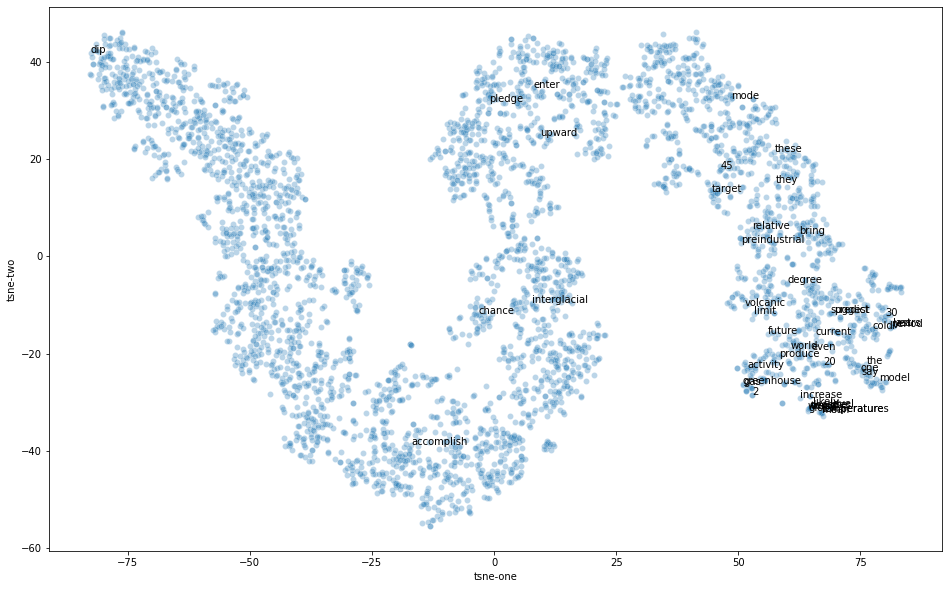

In [ ]:
df = pd.DataFrame()
df['tsne-one'] = tsne_test[:,0]
df['tsne-two'] = tsne_test[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)
for i, word in enumerate(list(test_embedding.keys())[:50]):
  plt.annotate(word,xy=(tsne_test[i,0],tsne_test[i,1]))

From the t-SNE plot is can be inferred that t-SNE is able to preserve both the local and global aspects of the data. t-SNE tends to expand denser regions of data. It magnifies the small empty spaces. It appears to form clusters of the data. 

We annotated few of the words in the subspace. t_SNE is able to preserve semantic relationship of the word embeddings in the lower dimension:
- The words 'greenhouse' and 'co2' appear closer in the t_SNE subspace similar to the word2vec embeddings.
- The words 'current' and 'future' of similar context appear closer in the plot. 
- Since 'dip' and 'increase' are in opposite context (generally), we see they appear in opposite ends of the plot. 

**Visualizing a subset of similar words in the t-SNE subspace**

Here we try to take a subset of few important words (as per the context of the dataset) and find 5 most similar words in the word2vec subspace. Applying t-SNE on these word clusters and visualizing them.

In [ ]:
# subset of words
keys = ['global', 'carbon', 'climate', 'winter', 'polar', 'june','melt','warm','glaciers']

embedding_clusters = []
word_clusters = []

# creating word cluster of the word subset and each of their 5 similar words in the word2vec subspace
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word, topn=5):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# applying t-SNE on the word cluster
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=0)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# t-SNE visualizing the word cluster.
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

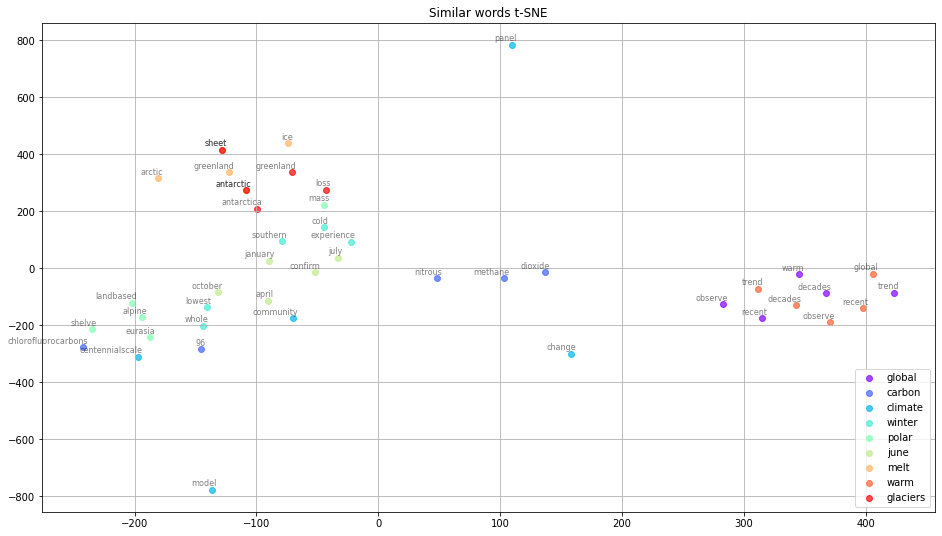

In [ ]:
tsne_plot_similar_words('Similar words t-SNE', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

From the above t-SNE plot of the word clusters, we observe:
- words similar to 'global'(purple color) and 'warm'(orange color) in the word2vec subspace appear together in the t-SNE subspace aswell.
- words similar to 'carbon'(dark blue) in the word2vec subspace are not appearing together in the t-SNE subspace. We see words like 'methane' , 'dioxide','nitrous' appear away from 'cluorofluorocarbon'
- most of the similar words in the word2vec subspace  effectively appear together other than few exceptions. We can say that semantic information is preserved with few information loss when projected in a lower dimension

**Comparison of LLE embeddings with Word2Vec embeddings**

In [ ]:
# map of test_set words and their word vectors after tSNE
test_embedding_tsne = {}
for key, i in zip(test_embedding.keys(), range(len(tsne_test))):
    test_embedding_tsne[key] = tsne_test[i]

In [ ]:
tsne_test_df = pd.DataFrame(tsne_test)

In [ ]:
cos_sim_tsne = cosine_similarity(tsne_test_df.iloc[:,:].values, Y=None, dense_output=False)
cos_df_tsne = pd.DataFrame(cos_sim_tsne, index = test_embedding_tsne.keys(), columns = test_embedding_tsne.keys())

Pair-wise cosine similarity : TSNE

In [ ]:
cos_df_tsne

,the,world,enter,cold,mode,likely,bring,global,dip,temperatures,last,20,30,years,say,one,target,suggest,limit,future,increase,mean,temperature,warm,2,relative,preindustrial,level,they,even,current,pledge,accomplish,chance,45,degree,rise,decades,greenhouse,gas,...,typical,λ,barrier,queensland,shark,drum,hook,kill,baby,stage,unfold,seabirds,wash,crescentic,1930s,postma,birth,climatology,automate,solution,apply,representation,try,experimental,theoretical,aside,wobble,henrik,svensmark,magnetic,deflect,nuclei,200year,component,reservoir,irregularly,periodic,subtropics,proper,heatwaves
the,1.000000,0.999821,-0.053707,0.995778,0.643917,0.987949,0.936767,0.984657,-0.982805,0.986675,0.994035,0.999324,0.991393,0.994102,0.999559,0.999789,0.840173,0.993514,0.997983,0.999986,0.988494,0.986672,0.986715,0.985185,0.977704,0.925026,0.943914,0.990036,0.858340,0.999992,0.999147,-0.307618,-0.130524,0.024785,0.795412,0.981677,0.989800,0.986342,0.981444,0.981069,...,0.383784,-0.980386,0.741001,-0.791574,-0.728159,-0.997364,-0.148196,0.929012,-0.987883,-0.553104,-0.634970,-0.896918,0.306104,-0.986669,-0.805578,-1.000000,0.330604,-0.989408,-0.994655,-0.906907,0.585751,0.223325,-0.433894,-0.858236,-0.513926,0.233761,-0.999437,0.737662,-0.564872,0.124866,-0.121570,-0.811467,-0.976901,0.971215,-0.506955,-0.610933,-0.302968,-0.991298,-0.659480,0.803815
world,0.999821,1.000000,-0.072612,0.993860,0.629309,0.990703,0.929971,0.987786,-0.986126,0.989580,0.991790,0.999841,0.988735,0.991870,0.999942,0.999999,0.829749,0.991182,0.996601,0.999707,0.991182,0.989577,0.989615,0.988256,0.981506,0.917664,0.937490,0.992525,0.848467,0.999888,0.998186,-0.325586,-0.111721,0.043717,0.783789,0.977892,0.992321,0.989285,0.984900,0.984562,...,0.401207,-0.983943,0.728149,-0.779857,-0.715046,-0.995810,-0.129437,0.921836,-0.990645,-0.537224,-0.620222,-0.888381,0.324081,-0.989575,-0.794210,-0.999835,0.348422,-0.991980,-0.996432,-0.898764,0.570294,0.241749,-0.450882,-0.848360,-0.497584,0.252136,-0.999893,0.750318,-0.580401,0.106050,-0.102747,-0.800252,-0.972677,0.975552,-0.490536,-0.595828,-0.284863,-0.993613,-0.645123,0.814939
enter,-0.053707,-0.072612,1.000000,0.038183,0.729408,-0.207619,0.299136,-0.227131,0.237163,-0.215461,0.055521,-0.090373,0.077486,0.054902,-0.083345,-0.074215,0.496413,0.060186,0.009791,-0.048468,-0.204129,-0.215480,-0.215219,-0.224162,-0.262196,0.329675,0.279021,-0.193786,0.466242,-0.057646,-0.012430,0.966658,-0.983004,-0.999581,0.562476,0.137554,-0.195417,-0.217445,-0.244183,-0.246067,...,-0.942702,0.249456,0.630737,-0.567678,-0.645311,-0.018892,-0.979571,0.319620,0.208036,-0.802204,-0.737320,-0.393387,-0.967064,0.215494,-0.548369,0.054476,-0.960163,0.198088,0.156528,-0.372015,0.777862,-0.985331,0.922967,-0.466421,-0.828995,-0.983446,0.087184,-0.713814,0.854325,0.984035,-0.984621,-0.539973,-0.160920,-0.290023,-0.833502,-0.757728,-0.935354,0.184690,-0.715218,-0.637191
cold,0.995778,0.993860,0.038183,1.000000,0.711431,0.969569,0.964936,0.964482,-0.961706,0.967574,0.999849,0.991731,0.999225,0.999860,0.992612,0.993681,0.886408,0.999757,0.999597,0.996246,0.970436,0.967569,0.967636,0.965282,0.954300,0.955994,0.970239,0.972929,0.901814,0.995408,0.998719,-0.218975,-0.220984,-0.067087,0.847688,0.995024,0.972544,0.967058,0.959698,0.959150,...,0.297398,-0.958155,0.799514,-0.844326,-0.788002,-0.999814,-0.238353,0.959059,-0.969465,-0.627244,-0.703204,-0.933723,0.217422,-0.967565,-0.856565,-0.995707,0.242575,-0.971906,-0.980977,-0.941754,0.657678,0.132905,-0.349358,-0.901727,-0.590501,0.143522,-0.992137,0.672570,-0.486740,0.215416,-0.212171,-0.861686,-0.992392,0.945248,-0.583940,-0.681027,-0.389171,-0.975028,-0.725701,0.745814
mode,0.643917,0.629309,0.729408,0.711431,1.000000,0.517734,0.870948,0.500529,-0.491573,0.510853,0.723521,0.615361,0.738541,0.723093,0.620906,0.628060,0.955927,0.726739,0.691188,0.647922,0.520782,0.510836,0.511066,0.503165,0.468899,0.886303,0.860431,0.529763,0.945256,0.640894,0.674960,0.529915,-0.842597,-0.748901,0.975880,0.777909,0.528351,0.509104,0

Pair-wise cosine similarity : Word2Vec

In [ ]:
cos_df_w2v

,the,world,enter,cold,mode,likely,bring,global,dip,temperatures,last,20,30,years,say,one,target,suggest,limit,future,increase,mean,temperature,warm,2,relative,preindustrial,level,they,even,current,pledge,accomplish,chance,45,degree,rise,decades,greenhouse,gas,...,typical,λ,barrier,queensland,shark,drum,hook,kill,baby,stage,unfold,seabirds,wash,crescentic,1930s,postma,birth,climatology,automate,solution,apply,representation,try,experimental,theoretical,aside,wobble,henrik,svensmark,magnetic,deflect,nuclei,200year,component,reservoir,irregularly,periodic,subtropics,proper,heatwaves
the,1.000000,0.937338,0.968786,0.952239,0.960934,0.837255,0.971266,0.720247,0.715307,0.750671,0.744719,0.884369,0.821662,0.731994,0.977662,0.974634,0.947227,0.990494,0.875383,0.925779,0.673646,0.747220,0.705202,0.753708,0.461802,0.928341,0.698303,0.597097,0.981432,0.924222,0.972921,0.965740,0.950678,0.942545,0.871414,0.957533,0.635585,0.824041,0.590267,0.585083,...,0.965016,0.909956,0.947795,0.970434,0.971101,0.972421,0.957405,0.944110,0.934453,0.960910,0.967745,0.949924,0.966876,0.871708,0.963741,0.971971,0.964282,0.943270,0.953505,0.909303,0.971124,0.968107,0.970604,0.970604,0.971410,0.962621,0.953635,0.966848,0.967817,0.957765,0.966007,0.956098,0.958722,0.971608,0.966586,0.957003,0.972193,0.940187,0.959345,0.971963
world,0.937338,1.000000,0.967958,0.893898,0.986443,0.784904,0.976682,0.642625,0.557467,0.637502,0.609252,0.934028,0.779456,0.629964,0.955126,0.964665,0.988085,0.932344,0.942993,0.942923,0.719382,0.652208,0.634266,0.687365,0.672245,0.911857,0.742408,0.576795,0.953722,0.973365,0.947418,0.978596,0.978520,0.979949,0.936410,0.963403,0.579887,0.744503,0.727036,0.746352,...,0.986459,0.960566,0.940551,0.968784,0.974561,0.968697,0.982109,0.966355,0.954245,0.974542,0.972136,0.950466,0.971149,0.858420,0.955052,0.975007,0.982292,0.939729,0.946317,0.980312,0.980833,0.974802,0.978598,0.966399,0.970495,0.985497,0.951643,0.978777,0.979502,0.986024,0.982035,0.983661,0.964075,0.981030,0.965127,0.942887,0.934128,0.941228,0.961900,0.965301
enter,0.968786,0.967958,1.000000,0.971733,0.989063,0.814853,0.997320,0.648694,0.705746,0.733730,0.744664,0.947454,0.874623,0.759276,0.965545,0.980053,0.982857,0.972058,0.900244,0.907244,0.689132,0.732589,0.702189,0.678809,0.582701,0.954876,0.772868,0.658952,0.975102,0.965136,0.945257,0.986193,0.978845,0.983040,0.933808,0.978377,0.665384,0.770829,0.585140,0.598058,...,0.989255,0.959925,0.985998,0.986461,0.988479,0.985847,0.991897,0.989527,0.969651,0.992862,0.992326,0.989295,0.997183,0.909250,0.990255,0.981095,0.992739,0.960598,0.982020,0.970510,0.990571,0.995235,0.994848,0.991740,0.984491,0.986705,0.971254,0.992253,0.992241,0.988422,0.990344,0.983817,0.984128,0.993113,0.994465,0.984662,0.986972,0.972888,0.985430,0.990646
cold,0.952239,0.893898,0.971733,1.000000,0.937119,0.825729,0.963222,0.667597,0.827435,0.817649,0.851302,0.911639,0.923114,0.852773,0.921143,0.943610,0.923115,0.963749,0.825637,0.845974,0.666847,0.806500,0.775264,0.686140,0.462534,0.950924,0.772625,0.702000,0.953585,0.911145,0.905768,0.943974,0.931394,0.934049,0.882444,0.948093,0.724773,0.790281,0.449296,0.446596,...,0.937028,0.904303,0.967289,0.960256,0.949934,0.949146,0.945768,0.952644,0.926033,0.954567,0.962053,0.968914,0.967694,0.898839,0.969564,0.935944,0.950197,0.924652,0.957159,0.903374,0.946882,0.958744,0.955457,0.962853,0.942577,0.935291,0.949067,0.951312,0.950584,0.940069,0.947554,0.929622,0.953053,0.954996,0.970062,0.976259,0.987471,0.949144,0.958023,0.967983
mode,0.960934,0.986443,0.989063,0.937119,1.000000,0.815511,0.994898,0.645639,0.639421,0.680320,0.696220,0.946664,0.833625,0.716002,0.980934,0.990217,0.996135,0.965333,0.926965,0.929087,0.692370,0.687846,0.656253,0.685762,0.629249,0.939075,0.750445,0.591573,0.975479,0.975027,0.953874,0.994190,0.989652,0.989300,0.943548,0.981621,0.601495,0.766836,0.657106,0.671928,...,0.997048,0.974734,0.975134,0.986581,0.992044,0.987871,0.996686,0.991743,0.976842,0.993649,0.991556,0.978942,0.989688,0.897906,0

From the above 2 dataframes of pair-wise cosine similarities, we can observe the cosine similarity values of each word in the test set and every other word in the set in the t-SNE and word2vec embedding space.

- Considering the absolute cosine similarities, we notice the cosine similarities are higher in the word2vec embedding space compared to the t-SNE embedding space. This is true for most of the words, signifying that some information is lost. For instance considering the words 'heatwaves' & cold':

  t-SNE cosine similarity : 0.745814

  Word2vec cosine similarity : 0.967983
 

In [ ]:
with open('test_embedding_tsne.txt', 'w', encoding="utf-8") as f: 
    f.write('%s %s\n' % (len(test_embedding_tsne.keys()), 2))
    for key, value in test_embedding_tsne.items():
        f.write('%s %s %s\n' % (key, value[0],value[1]))

In [ ]:
tsne_model = gensim.models.KeyedVectors.load_word2vec_format('test_embedding_tsne.txt', binary=False)

In [ ]:
tsne_model.most_similar('carbon')

[('dioxide', 0.9999999403953552),
 ('2', 0.9999989867210388),
 ('co', 0.9999988079071045),
 ('methane', 0.999996542930603),
 ('perry', 0.9999657273292542),
 ('assign', 0.9999539256095886),
 ('inhofe', 0.9999450445175171),
 ('hawaii', 0.9998895525932312),
 ('gas', 0.9998834133148193),
 ('detection', 0.9998701810836792)]

In [ ]:
model.most_similar('carbon')

[('methane', 0.9804165363311768),
 ('chlorofluorocarbons', 0.9779826402664185),
 ('dioxide', 0.9746006727218628),
 ('nitrous', 0.9659712314605713),
 ('96', 0.9649980068206787),
 ('tropospheric', 0.9622126817703247),
 ('49', 0.9581986665725708),
 ('nonco2', 0.9581005573272705),
 ('oxide', 0.9576266407966614),
 ('release', 0.9563332200050354)]

We see the word 'carbon' is most similar to 'dioxide' in the t-SNE subspace whereas similar to 'methane' in the word2vec subspace.
Similarly considering the cosine similarities for 'carbon' & 'dioxide':

t-SNE subspace : 0.9999999403953552

Word2vec subspace : 0.9746006727218628

In both the subspace, the most similar words appear in similar context as both 'dioxide' and 'methane' are relevant to 'carbon'

In [ ]:
tsne_model.most_similar('glaciers')

[('greenland', 0.9999998211860657),
 ('melt', 0.9999997615814209),
 ('other', 0.9999997615814209),
 ('peerreviewed', 0.9999997019767761),
 ('antarctica', 0.9999996423721313),
 ('sheet', 0.9999995231628418),
 ('today', 0.9999994039535522),
 ('2013', 0.9999994039535522),
 ('cover', 0.9999993443489075),
 ('31000', 0.9999991059303284)]

In [ ]:
model.most_similar('glaciers')

[('antarctic', 0.9970004558563232),
 ('greenland', 0.9952079653739929),
 ('loss', 0.988825798034668),
 ('antarctica', 0.9882369637489319),
 ('sheet', 0.9868824481964111),
 ('alpine', 0.9844338297843933),
 ('shrinkage', 0.9840260148048401),
 ('snow', 0.9806098341941833),
 ('landbased', 0.9798789024353027),
 ('mass', 0.9784616231918335)]

Considering the word 'glacier', we see both the models identify similar context words 'greenland' and 'antarctica', 'sheet' . For the word 'sheet',

t-SNE : 0.9998705387115479

Word2vec: 0.9868824481964111

Similarly considering the context word 'greenland':

t-SNE: 0.9987722039222717

Word2vec: 0.9952079653739929

In [ ]:
tsne_model.most_similar('june')

[('5', 0.9999999403953552),
 ('earlier', 0.999998927116394),
 ('drop', 0.9999982714653015),
 ('later', 0.9999980330467224),
 ('ft', 0.9999977946281433),
 ('late', 0.9999963641166687),
 ('observations', 0.9999958276748657),
 ('instrumental', 0.9999943971633911),
 ('month', 0.9999911785125732),
 ('introduction', 0.9999908208847046)]

In [ ]:
model.most_similar('june')

[('july', 0.9989757537841797),
 ('january', 0.9989748001098633),
 ('confirm', 0.9987897276878357),
 ('april', 0.9987339973449707),
 ('october', 0.9985716342926025),
 ('1988', 0.9983054399490356),
 ('august', 0.9980118870735168),
 ('february', 0.9979966282844543),
 ('december', 0.9978994727134705),
 ('seven', 0.9976174831390381)]

t-SNE did not effectively preserve the semantic relationship for the word 'june'. We can observe many out of context words for the t-sne model. 

**KNN graph TSNE**

In [ ]:
from sklearn.neighbors import kneighbors_graph
A_tsne = kneighbors_graph(tsne_test_df, 5)

In [ ]:
A_tsne.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

We obtain the adjacency matrix, which has the value 1 for the 5 closest neighbours of each word and 0 for every other datapoint.

Comparing the adjacency matrix for the word2vec embeddings and the the t-SNE emeddings for the test set, we obtain the f1_score of the embeddings indicating the extent of similarity between them. 

The f1-score is particularly useful in this case when the class distubution is uneven. It specifies on average what percent of neighbors for each word are same in word2vec embeddings and t_SNE embeddings.

In [ ]:
A_tsne = A_tsne.toarray()

In [ ]:
row,column = A_tsne.shape

In [ ]:
f1_score_tsne_sum =0

for i in range(column):
  f1_score_tsne_sum = f1_score_tsne_sum + f1_score(A_word2vec[:,i], A_tsne[:,i])
f1_score_tsne = f1_score_tsne_sum/column

In [ ]:
f1_score_tsne

0.48610642873100635

On comparing the KNN-graphs (sparce matrix) columnwise, we compute the average f1_score for the t-SNE and the Word2vec test embedding.
We observe that on average 48% of the neighbours of each word in the word2vec embeddings space are same as neighbours in the t-SNE embedding space.
Thus some information is lost while conversion to a lower dimension.

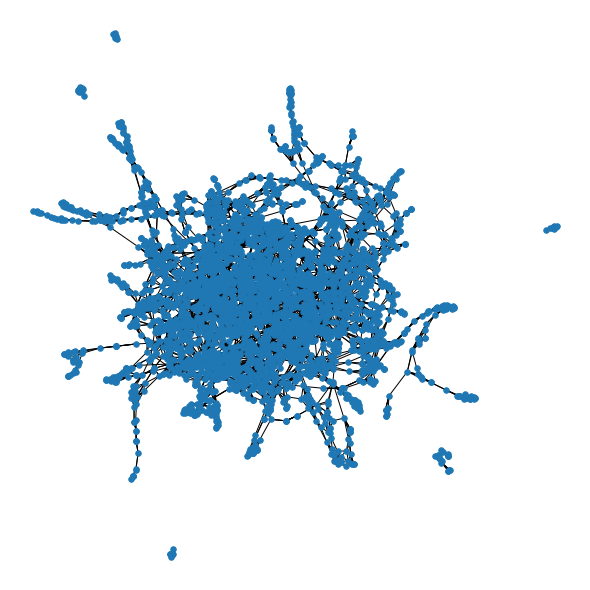

In [ ]:
fig = plt.figure(figsize=(8,8))
show_graph(A_tsne)

In [ ]:
test_embedding_tsne_100 = dict(itertools.islice(test_embedding_tsne.items(),101))
test_word_labels_tsne = make_label_dict(test_embedding_tsne_100.keys())

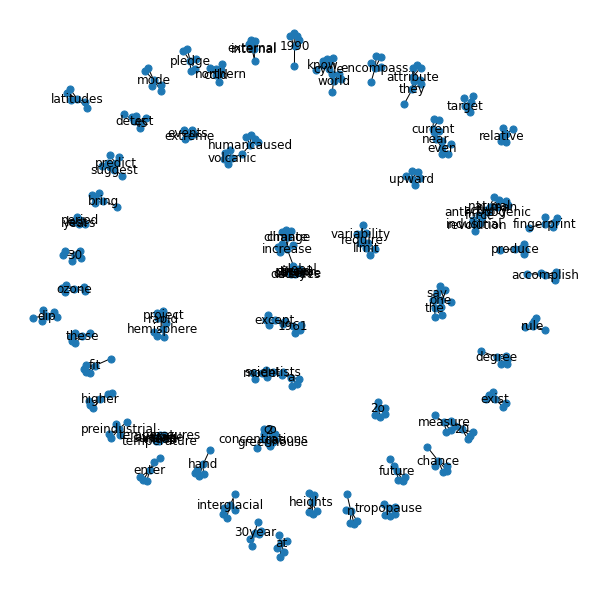

In [ ]:
fig = plt.figure(figsize=(8,8))
show_graph_with_labels(A_tsne[:101], test_word_labels_tsne)

From visualization of KNN graph of t-SNE embeddings for subset of words from test set:
- Words like 'climate' and 'change' appear closer as was the case in w2vec embeddings
- Words like 'greenhouse' and 'c02' appear closer as was the case in w2vec embeddings.
- Words like 'external' and 'internal' which appear in similar context are together as was the case with w2vec embeddings.
- We notice similar context words like 'future' and 'current' far from each other (contrary to w2vec embeddings)
- Words 'northern' and 'cold' are closer to each other (similar case to w2vec embeddings) 
-  Words 'increase' and 'higher' are not closer to each other (contrary to w2vec embeddings)